# ROI Size and Shape Evaluation

In [44]:
import pandas as pd
import sys
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [12]:
manual_seg_path = "manual_segmentation.xlsx"
thresh_seg_path = "threshold_segmentation.xlsx"

In [13]:
path = thresh_seg_path
df = pd.read_excel(path)
df.head()

,,Area1,Mean1,Min1,Max1,XM1,YM1,BX1,BY1,Width1,...,Feret59,IntDen59,RawIntDen59,FeretX59,FeretY59,FeretAngle59,MinFeret59,AR59,Round59,Solidity59
0,1,4943,-0.437,-0.524,-0.301,202.459,146.558,1,1,346,...,17.205,-79.925,-79.925,307,245,125.538,14,1.072,0.933,0.935
1,2,4943,-0.434,-0.536,-0.300,202.344,146.665,1,1,346,...,17.205,-79.855,-79.855,307,245,125.538,14,1.072,0.933,0.935
2,3,4943,-0.436,-0.522,-0.303,202.474,146.566,1,1,346,...,17.205,-79.995,-79.995,307,245,125.538,14,1.072,0.933,0.935
3,4,4943,-0.435,-0.529,-0.286,202.602,146.581,1,1,346,...,17.205,-79.948,-79.948,307,245,125.538,14,1.072,0.933,0.935
4,5,4943,-0.435,-0.521,-0.302,202.495,146.516,1,1,346,...,17.205,-79.898,-79.898,307,245,125.538,14,1.072,0.933,0.935


Okay, so a few things:

1. Ferets cannot be longer than a certain amount because uh
2. Area so the things can be checked by area
3. Circularity, ones under a certain circularity can be discarded
4. Line profile. For this we can get the co ordinates of the box, apply it to the f380 image and draw a line and see the intensity, the other things are easy so I am actually going to start with this

## Feret

https://imagej.nih.gov/ij/docs/guide/146-30.html
Okay so feret's diameter gives the max diameter of a ROI. ie max should not be smaller than 10u or larger than 30u. Conversion wise 1px = 1.3u for an image which is 340px by 260px . So, 

     23.1px < feret > 7.6px

Feret - maximum caliper/ diameter
FeretX and Y - starting co ordinates of the Feret diameter
MinFeret - minimum caliper

So then here we extract the ROI numbers which contain Ferets of the correct size

In [131]:
def feret_diam_test(df):
    min_feret_diameter = 7.6
    max_feret_diameter = 23.1
    all_feret_df = df.filter(regex=("Feret.*"), axis=1)
    #I need to drop the FeretX, FeretY , MinFeret and FeretAngle columns
    cols = [c for c in all_feret_df.columns if 'X' not in c and 'Y'not in c and 'M' not in c and 'Angle' not in c]
    feret_df = all_feret_df[cols]
    #accepted_ferret = [ferret for ferret in feret.iloc[1] if ferret > min_feret_diameter and ferret < max_feret_diameter]
    max_ferret = feret_df.columns[(feret_df < max_feret_diameter).iloc[0]]
    min_ferret = feret_df.columns[(feret_df > min_feret_diameter).iloc[0]]
    common = list(set(list(max_ferret)).intersection(list(min_ferret)))
    print ("Number of cells regions originally: ", len(feret_df.iloc[1]))
    print ("Number of cells with suitable Feret diamter: ", len(common))
    return common

In [132]:
passed_ferret_test = feret_diam_test(df)
print(len(passed_ferret_test))

Number of cells regions originally:  59
Number of cells with suitable Feret diamter:  28
28


## Circularity 

Circulaity gives an indication of how round the shapes are.

    circularity = 4pi x (area/(perimeter^2))
    
https://imagej.nih.gov/ij/docs/guide/146-30.html

I still have to decide on a suitable circularity value. I am not so sure how to decide this. Perhaps I can check all the cells that have signal responses and then check their circulairty and then use the average of what I can getfrom that

In [364]:
def circularity_test(df):
    min_circ = 0.5
    circ_df = df.filter(regex=("Circ.*"), axis=1)
    #accepted_circ = [circ for circ in circ_df.iloc[1] if circ > min_circ]
    accepted_circvals = circ_df.columns[(circ_df > min_circ).iloc[0]]
    print ("Number of cells regions originally: ", len(circ_df.iloc[1]))
    print ("Number of cells with suitable circularity: ", len(accepted_circvals))
    return accepted_circvals

In [365]:
passed_circ_test = circularity_test(df)

Number of cells regions originally:  59
Number of cells with suitable circularity:  56


In [126]:
def circularity_test_on_passed_ferret(ferret_ar, df):
    import re
    passed_feret_roinum = []
    for roi in ferret_ar:
        passed_feret_roinum.append(re.findall('\d+', roi )) 
    min_circ = 0.5
    circ_df = df.filter(regex=("Circ.*"), axis=1)
    circ_columns = []
    for column in circ_df.columns:
        if re.findall('\d+', column ) in passed_feret_roinum:
            circ_columns.append(column)

    passedferret_circdf = circ_df.filter(circ_columns, axis=1)
    #accepted_circ = [circ for circ in circ_df.iloc[1] if circ > min_circ]
    accepted_circvals = passedferret_circdf.columns[(passedferret_circdf > min_circ).iloc[0]]
    print ("Number of cells regions originally: ", len(circ_df.iloc[1]))
    print ("Number of cells with suitable circularity and feret number: ", len(accepted_circvals))
    return accepted_circvals

In [125]:
passed_circ_test = circularity_test_on_passed_ferret(passed_ferret_test, df)

Number of cells regions originally:  59
Number of cells with suitable circularity and feret number:  23


## Line Profile

I need to be able to get a line accross the roi. Actually it would be best to get the line at the angle of the feret, which I actually have so I can use it. But for now I just need to get the intensities of a certain line of pixels in the image (data set 2, image) as decided by the ROI (data set 1, excel sheet) 

We use the bounding box, which gives BX and BY which are the co ordinates of the upper left corner of the box

In [4]:
from PIL import Image, ImageDraw

im = Image.open('std_ratio.jpg')
plt.imshow(im, interpolation='nearest')
pixels = list(im.getdata())
width, height = im.size
#this puts the long array of values into a list of lists (actually rows within the image)
pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]
#print (len(pixels), len(pixels[1]))

(348, 260)

In [8]:
def boundbox_params(roi_number):
    regex_string = roi_number + '.*'
    roi_df = df.filter(regex=(regex_string), axis=1)
    bx_roi = roi_df["BX" + roi_number ][0]
    by_roi = roi_df["BY" + roi_number][0]
    b_width = roi_df["Width" + roi_number][0]
    b_height = roi_df["Height" + roi_number][0] 
    return (bx_roi, by_roi, b_width, b_height)

The translation for co ordinates (x, y) to be referenced in the pixels data thing is (y-1, x-1) and that will return the same pixel value

Horizontal Profile

In [19]:
def horizontal_profile(bx_roi, by_roi, b_height, b_width):
    # and so but we want a horizontal line from (191, 207 + 14/2) to (191+12, 207+(14/2))
    # translated by our system we want (213, 190) to (213,202)
    falsex = bx_roi - 1
    falsey = int(by_roi + (b_height/2)) -1
    histo_hor = []
    for x in range(falsex, falsex + b_width ):
    #for x in range(190, 202):
        histo_hor.append(pixels[falsey][x])
    plt.plot(histo_hor) 
    plt.show()
    return histo_hor

Vertical Profile

In [50]:
def vertical_profile(bx_roi, by_roi, b_height, b_width):
    # and so but we want a vertical line from (191 + 12/2, 207) to (191+12/2, 207+14)
    # translated by our system we want (206, 196) to (220,196)
    falsex = int (bx_roi + b_width/2) -1
    falsey = by_roi -1 
    histo_vert = []
    for y in range(falsey, falsey + b_height):
    #for y in range(206, 220):
        histo_vert.append(pixels[y][falsex])
    plt.plot(histo_vert) 
    plt.show()
    return histo_vert

Pearson gaussian correlation coeff

In [89]:
def pearson_gauss_fir(y_vals):
    import pylab as plb
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp
    from scipy import stats

    x = ar(range(len(y_vals)))
    y = ar(y_vals)

    n = len(x)                          #the number of data
    #mean = sum(x*y)/n                   #note this correction
    #sigma = sum(y*(x-mean)**2)/n        #note this correction

    def gaus(x,a,x0,sigma):
        return a*exp(-(x-x0)**2/(2*sigma**2))

    popt,pcov = curve_fit(gaus,x,y)
    plt.plot(x,y,'b+:',label='data')
    plt.plot(x,gaus(x,*popt),'ro:',label='fit')
    plt.legend()
    plt.title('Vertical LIne profile with Gaussian Fit')
    plt.xlabel('Relative Vertical Position in ROI')
    plt.ylabel('Grey Value')
    plt.show()

    return stats.pearsonr(gaus(x,*popt), y)

The most familiar measure of dependence between two quantities is the Pearson product-moment correlation coefficient,
https://en.wikipedia.org/wiki/Correlation_and_dependence#Pearson.27s_product-moment_coefficient

Returns :

(Pearson’s correlation coefficient, : 2-tailed p-value)

Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

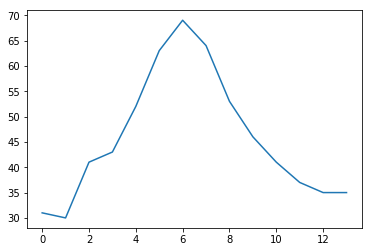

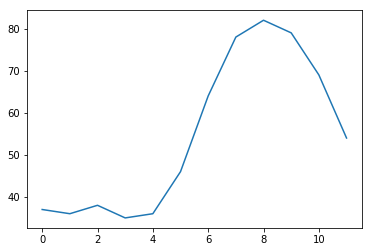

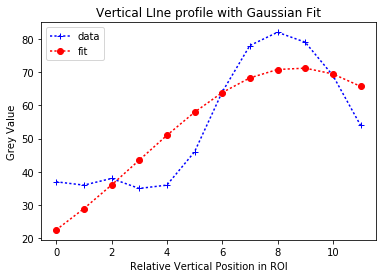

(0.8485688587280783, 0.00048355617456092794)


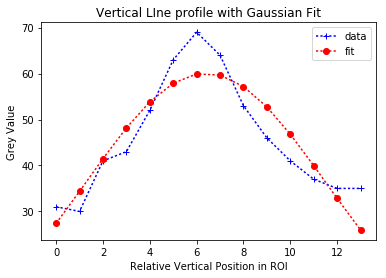

(0.90517560727606894, 8.5326959301398425e-06)


In [96]:
roi = '49'
x, y, height, width = boundbox_params(roi)
histo_hor =  horizontal_profile(x, y, height, width)
histo_vert =  vertical_profile(x, y, height, width)
result = pearson_gauss_fir(histo_vert)
print(result)
result = pearson_gauss_fir(histo_hor)
print(result)
